In [13]:
import collections
import io
import time
import math
import logging
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

In [14]:
evaluation_measures = ['ndcg_cut_10', 'map_cut_1000', 'P_5', 'recall_1000']
trec_eval_directory = '../trec_eval' # required dir format: trec_eval(results_test(...),results_validation(...))

scores = collections.defaultdict(lambda : collections.defaultdict(dict))
scores_per_querry = collections.defaultdict(lambda : collections.defaultdict(lambda:collections.defaultdict(dict)))


#GATHERING ALL NECESSARY SCORES
for directory in os.listdir(os.fsencode(trec_eval_directory)):
    for file in os.listdir(os.path.join(os.fsencode(trec_eval_directory), directory)):
        for line in open(os.path.join(os.fsencode(trec_eval_directory), directory,file)):
            evaluation_type, querry, score = line.split()
            if querry == 'all' and evaluation_type in evaluation_measures:
                scores[os.fsdecode(directory)][os.fsdecode(file)[:-4]][evaluation_type] = score
            elif evaluation_type in evaluation_measures:
                scores_per_querry[os.fsdecode(directory)][os.fsdecode(file)[:-4]][evaluation_type][querry] = score

In [15]:
class ExperimentSetup:
    def __init__(self, name, param_name, parameters, values):
        self.name = name
        self.param_name = param_name
        self.parameters = parameters
        self.values = values
        
language_models = ['jm','dp','ad','plm']
graph_data = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
for key in scores['results_test'].keys():
    if key.split('_')[0] in language_models:
        graph_data[key.split('_')[0]]['values'].append(float(scores['results_test'][key]['ndcg_cut_10']))
        graph_data[key.split('_')[0]]['parameters'].append(key.split('_')[-1])

for key in graph_data.keys():
    graph_data[key]['parameters'] = np.array(graph_data[key]['parameters'], dtype=float)  # form array to numpy.array
    sort_indexes = np.argsort(graph_data[key]['parameters'])
    graph_data[key]['parameters'] = graph_data[key]['parameters'][sort_indexes]  # sort
    graph_data[key]['values'] = np.array(graph_data[key]['values'], dtype=float)[sort_indexes] # form array to numpy.array and sort
    
    
        
experiments = [ExperimentSetup("Jelinek-Mercer","λ",graph_data['jm']['parameters'],graph_data['jm']['values']),
                ExperimentSetup("Dirichlet Prior","μ",graph_data['dp']['parameters'],graph_data['dp']['values']),
                ExperimentSetup("Absolute Discounting","δ",graph_data['ad']['parameters'],graph_data['ad']['values']),
              ExperimentSetup("Positional Language Model","μ",graph_data['plm']['parameters'],graph_data['plm']['values'])]

def plot_results(experiments, title):
    ax = plt.subplot(111)
    ax.get_xaxis().set_visible(True)
    bar_width = 1
    
    plt.title(title)
    
    mm = ''
    for ex in experiments:
        mm = mm + ex.name + "=" + ex.param_name + "\n"
    ax.annotate(mm, xy=(0.05,0.5),xycoords='axes fraction',fontsize=14)
    

    label_x = []
    label_values = []
    padding=0

    for algorithm_index, experiment in enumerate(experiments):
        bars = np.arange(0,bar_width*(len(experiment.parameters)+1),bar_width)[:len(experiment.parameters)]
        mean = bars.mean()
        bars = bars - mean

        colors = ['indianred', 'red','maroon']
        rects1 = ax.bar(bars + padding, experiment.values, width = bar_width, color=colors, align='center')
        
        label_x.append(padding)
        label_values.append(experiment.name)
        
        padding += (bar_width*len(experiment.parameters)+bar_width) 
        
#       Attach a text label above each bar displaying its paramtere
        for index, rect in enumerate(rects1):
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*height,'%s' % experiment.parameters[index],rotation='30', ha='center', va='bottom')
    plt.xticks(label_x, label_values, rotation='10')
    
    plt.show()

The following tables contains the scores for each of the evaluation measures, evaluated on the validation set:

|    Absolute Discounting    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| delta=0.1 |0.1885 |0.1422 | 0.1833|0.3314 |
| delta=0.5 |0.1941 |0.1446 |0.1833 | 0.3334|
| delta=0.9 | 0.1944|0.1459 | 0.1833 |0.3322 |

|    Dirichlet Prior    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| mu=500 |0.2235 |0.1453 | 0.2167|0.3322 |
| mu=1000 |0.2195 |0.1454 |0.2333 | 0.3293|
| mu=1500 | 0.2192|0.1457 | 0.2333 |0.3268 |

|    Jelinek-Mercer    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| lambda=0.1 |0.1888 |0.1418 | 0.1833|0.3240 |
| lambda=0.5 |0.1888 |0.1416 |0.1833 | 0.3295|
| lambda=0.9 | 0.1888|0.1416 |0.1833 |0.3310 |

|    Positional Language Model    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| mu=1000 |0.2642 |0.1489 | 0.2500|0.3412 |
                           
|    TD-IDF    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
|  |0.3548 |0.2420 | 0.3500|0.7203 |

|    BM25    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
|  |0.3232 |0.2582 | 0.3167|0.7249 |


Having the information in the tables above, the report of evaluation measures using the optimised hyperparameters can be found in the following table(the hyperparameter can be found between paranthesis):

|    Jelinek-Mercer    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| TD-IDF |0.3973|0.1979|0.4000|0.5542|
| BM25 (k1=1.2, b=0.75) |0.3689|0.1957|0.3526|0.5623|
| Jelinek-Mercer (0.1)|0.0480|0.0264|0.0526|0.1738|
| Dirichlet Prior (500)|0.0863|0.0336|0.0895|0.1877|
| Absolute Discounting (0.9)|0.0588|0.0295|0.0684|0.1998|
| Positional Language Model (1000)|0.3136|0.1113|0.3263|0.2589|

Given that for the Positional Language Model the training of the model needs too much resources in terms of time, we run it once with $\mu = 1000$, and only on the first 50 querries. In consequence, for a better comparison, all other language models were trained on the first 50 querries as well.

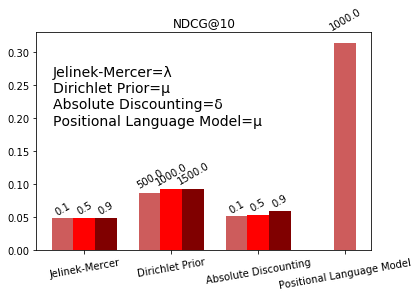

In [16]:
plot_results(experiments,'NDCG@10')

Compute significance of the results using a two-tailed paired Student t-test [5 points]. Be wary of false rejection of the null hypothesis caused by the multiple comparisons problem. There are multiple ways to mitigate this problem and it is up to you to choose one.

In [64]:
#GET NECESSARY DATA.
chosen = collections.defaultdict(lambda: collections.defaultdict(dict))
algor_names = ['ad_delta_0.9', 'bm25', 'dp_mu_500', 'jm_lambda_0.1', 'tfidf', 'plm_mu_1000']
for alg in algor_names:
    for metric in evaluation_measures:
        chosen[metric][alg] = scores_per_querry['results_test'][alg][metric]
        sorted_querries = np.sort(np.array(list(chosen[metric][alg].keys()), dtype=int))
        chosen[metric][alg]=[chosen[metric][alg][str(querry)] for querry in sorted_querries]
        
twoTailedStudentT_Test = collections.defaultdict(lambda: collections.defaultdict(dict))
for metric in chosen.keys():
    for algorithm1 in chosen[metric].keys():
        for algorithm2 in chosen[metric].keys():
            if algorithm1 != algorithm2:
                statistic,pvalue = stats.ttest_rel(np.array(chosen[metric][algorithm1], dtype=float),np.array(chosen[metric][algorithm2], dtype=float))
#                 if p < (0.05)/15:
#                     print(metric, algorithm1.split('_')[0],algorithm2.split('_')[0])
                twoTailedStudentT_Test[metric][(min(algorithm1.split('_')[0],algorithm2.split('_')[0]),max(algorithm1.split('_')[0],algorithm2.split('_')[0]))] = (statistic,pvalue)
                
for metric in chosen.keys():
    ad=chosen[metric]['ad_delta_0.9']
    bm25=chosen[metric]['bm25']
    dp=chosen[metric]['dp_mu_500']
    jm=chosen[metric]['jm_lambda_0.1']
    tfidf=chosen[metric]['tfidf']
    plm=chosen[metric]['plm_mu_1000']
    statistic , pvalue = stats.f_oneway(ad,dp,jm,bm25,tfidf,plm)
    if pvalue < 0.05:
        print("For metrix '{}', the one-way ANOVA test resulted in a p-value less than {}( = {}), meaning that the groups do not have the same population mean.".format(metric,0.05, pvalue))
        

For metrix 'ndcg_cut_10', the one-way ANOVA test resulted in a p-value less than 0.05( = 2.2794658794892968e-11), meaning that the groups do not have the same population mean.
For metrix 'map_cut_1000', the one-way ANOVA test resulted in a p-value less than 0.05( = 7.477929095647376e-10), meaning that the groups do not have the same population mean.
For metrix 'P_5', the one-way ANOVA test resulted in a p-value less than 0.05( = 1.1482029941969017e-09), meaning that the groups do not have the same population mean.
For metrix 'recall_1000', the one-way ANOVA test resulted in a p-value less than 0.05( = 3.6191932131433935e-15), meaning that the groups do not have the same population mean.


In [65]:
twoTailedStudentT_Test

defaultdict(<function __main__.<lambda>>,
            {'P_5': defaultdict(dict,
                         {('ad', 'bm25'): (4.8792118067625987,
                           2.0475981901952747e-05),
                          ('ad', 'dp'): (1.275293545178374,
                           0.21015490249604474),
                          ('ad', 'jm'): (-1.7808505191139909,
                           0.083148775395510882),
                          ('ad', 'plm'): (4.5321459399283741,
                           5.9237789035274328e-05),
                          ('ad', 'tfidf'): (5.0331486984045934,
                           1.2732069853844295e-05),
                          ('bm25', 'dp'): (-4.3572976364874645,
                           0.00010055355976881276),
                          ('bm25', 'jm'): (-5.1451728199624487,
                           8.9998580329673762e-06),
                          ('bm25', 'plm'): (-0.70960438118001679,
                           0.48239769357391582),
       

When we test Absolute Discounting, Dirichlet Prior and Jelinek-Mercer with the one-way ANOVA test, the null hypothesis is not rejected for neither of the metric used (i.e. ndcg@10, map@1000, P@5, recall@1000).
Testing BM25, TF-IDF, Positional Language Model gives us that only for recall@1000 the null hypothesis is rejected.
Furthermore, when we test all six algorithms, for all metrics the null hypothesis is rejected. This means that we have two groups of algorithms: Absolute Discounting, Dirichlet Prior, Jelinek-Mercer in one group, and BM25, TF-IDF, Positional Language Model in the other.

Computing the significance of the results using a two-tailed paired Student t-test supports the above statements.

In the following table we can clearly see that for Precision@5, the differences are significant between the groups, but within the groups, the results are similar. For all other metrics(i.e. ndcg@10, map@1000, recall@1000), the results are smilar.

|Precision@5              |Absolute Discounting|Dirichlet Prior| Jelinek-Mercer | TF-IDF  |   BM25  |Positional Language Model|
|-------------------------|--------------------|---------------|----------------|---------|---------|-------------------------|
|Absolute Discounting     |   -                |    0.21015    |    0.08314     | 0.00001 | 0.00002 |         0.00005          |
|Dirichlet Prior          | 0.21015            |         -     |    0.05083     | 0.00004 | 0.00010 |         0.00024          |
|Jelinek-Mercer           | 0.08314            |    0.05083    |      -         | 0.00000 | 0.00000 |         0.00003          |
|TF-IDF                   | 0.00001            |    0.00004    |    0.00000     |   -     | 0.09502 |         0.07496          |
|BM25                     | 0.00002            |    0.00010    |    0.00000     | 0.09502 |   -     |         0.48239          |
|Positional Language Model| 0.00005            |    0.00024    |    0.00003     | 0.07496 | 0.48239 |           -              |

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is very important in order to understand how the different retrieval functions behave.